In [1]:
"""
Gene-level clustering analysis setup and imports.
"""

# Standard library imports
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns


# Machine learning
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Visualization
from cycler import cycler
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ All imports successful")
logger.info("Setup complete")


2025-08-04 11:27:06,688 - INFO - Setup complete


✓ All imports successful


## ⚙️ Professional Styling Configuration

Set up consistent, publication-ready styling for all plots.

In [2]:
# Professional styling configuration
def setup_plot_style():
    """Configure matplotlib with professional, publication-ready defaults."""
    
    # General appearance
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white',
        'savefig.dpi': 300,
        'figure.dpi': 100,
        
        # Typography
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 10,
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.labelsize': 14,
        'axes.labelweight': 'semibold',
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        
        # Line and marker properties
        'axes.linewidth': 2.0,
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'patch.linewidth': 2.0,
        
        # Spine and tick properties
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.bottom': True,
        'xtick.top': False,
        'ytick.left': True,
        'ytick.right': False,
        
        # Grid properties
        'axes.grid': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'axes.axisbelow': True,
        
        # Legend properties
        'legend.frameon': True,
        'legend.numpoints': 1,
    })

def clean_axes(ax):
    """Apply clean styling to axes - removes top and right spines."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.grid(True, alpha=0.3, linewidth=0.8)
    return ax

def add_stats_annotation(ax, text, x=0.05, y=0.95):
    """Add statistical annotation to plot."""
    ax.text(x, y, text, transform=ax.transAxes, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
           verticalalignment='top', fontsize=9)

def save_plot(fig, filename, formats=['png', 'svg'], dpi=300):
    """Save plot in multiple formats with consistent settings."""
    for fmt in formats:
        filepath = Path(f"{filename}.{fmt}")
        fig.savefig(filepath, format=fmt, dpi=dpi, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    print(f"Plot saved as: {', '.join([f'{filename}.{fmt}' for fmt in formats])}")

# Apply the styling
setup_plot_style()
print("Professional styling configuration applied!")

# Standard figure sizes for different use cases
FIGURE_SIZES = {
    'small': (4, 3),      # Single plots, supplements
    'medium': (6, 4.5),   # Standard journal figures  
    'large': (8, 6),      # Complex plots with multiple elements
    'wide': (10, 4),      # Time series, genomic data
    'square': (4, 4),     # Correlation plots, heatmaps
}

FIGURE_DPI = 300

print("Available figure sizes:", list(FIGURE_SIZES.keys()))


Professional styling configuration applied!
Available figure sizes: ['small', 'medium', 'large', 'wide', 'square']


## 🎨 Custom Color Palette

Professional color palette organized by hue families for better visual harmony and accessibility.


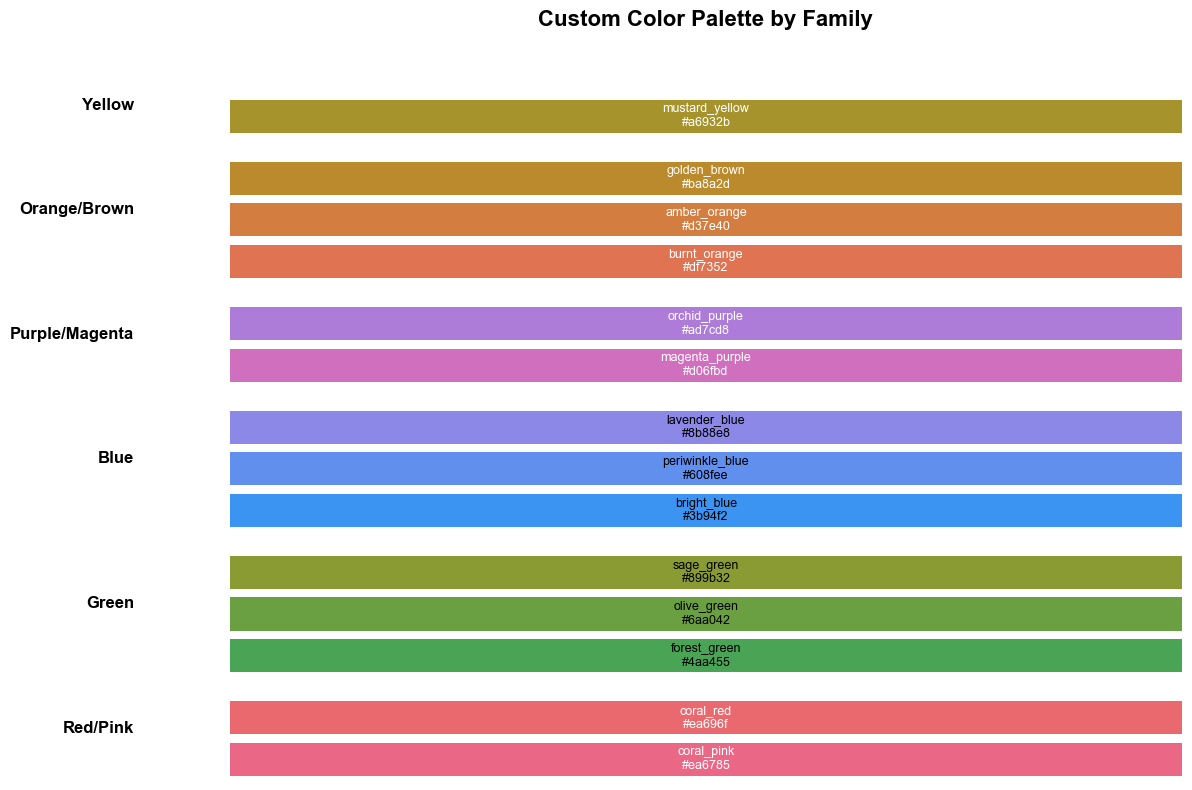

Color palette loaded successfully!
Primary trio: ['#ea696f', '#6aa042', '#608fee']
Four-category palette: ['#ea696f', '#6aa042', '#608fee', '#ad7cd8']


In [3]:
# Custom Color Palette - Organized by families
COLORS = {
    'coral_pink': '#ea6785',
    'forest_green': '#4aa455',
    'bright_blue': '#3b94f2',
    'magenta_purple': '#d06fbd',
    'golden_brown': '#ba8a2d',
    'coral_red': '#ea696f',
    'olive_green': '#6aa042',
    'periwinkle_blue': '#608fee',
    'burnt_orange': '#df7352',
    'sage_green': '#899b32',
    'lavender_blue': '#8b88e8',
    'amber_orange': '#d37e40',
    'mustard_yellow': '#a6932b',
    'orchid_purple': '#ad7cd8'
}

# Recommended color combinations
PRIMARY_TRIO = [COLORS['coral_red'], COLORS['olive_green'], COLORS['periwinkle_blue']]
FOUR_CATEGORY = PRIMARY_TRIO + [COLORS['orchid_purple']]
SIX_CATEGORY = FOUR_CATEGORY + [COLORS['magenta_purple'], COLORS['golden_brown']]

# Set as default matplotlib color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=PRIMARY_TRIO)

# Display color palette
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
families = {
    'Red/Pink': ['coral_pink', 'coral_red'],
    'Green': ['forest_green', 'olive_green', 'sage_green'],
    'Blue': ['bright_blue', 'periwinkle_blue', 'lavender_blue'],
    'Purple/Magenta': ['magenta_purple', 'orchid_purple'],
    'Orange/Brown': ['burnt_orange', 'amber_orange', 'golden_brown'],
    'Yellow': ['mustard_yellow']
}

y_pos = 0
for family_name, color_names in families.items():
    for i, color_name in enumerate(color_names):
        ax.barh(y_pos, 1, color=COLORS[color_name], height=0.8)
        ax.text(0.5, y_pos, f'{color_name}\n{COLORS[color_name]}', 
               ha='center', va='center', fontsize=9, 
               color='white' if color_name in ['coral_pink', 'coral_red', 'magenta_purple', 'orchid_purple', 'burnt_orange', 'amber_orange', 'golden_brown', 'mustard_yellow'] else 'black')
        y_pos += 1
    y_pos += 0.5  # Add space between families
    
    # Add family label
    ax.text(-0.1, y_pos - len(color_names)/2 - 0.75, family_name, 
           ha='right', va='center', fontsize=12, weight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, y_pos)
ax.set_title('Custom Color Palette by Family', fontsize=16, weight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

print("Color palette loaded successfully!")
print(f"Primary trio: {PRIMARY_TRIO}")
print(f"Four-category palette: {FOUR_CATEGORY}")

def create_gradient_colormap(base_color, name='custom_gradient'):
    """
    Create a gradient colormap from white to a given base color.
    
    Args:
        base_color: Base color (can be hex string, RGB tuple, or named color)
        name: Name for the colormap
        
    Returns:
        matplotlib.colors.LinearSegmentedColormap
    """
    # Convert base color to RGB if needed
    if isinstance(base_color, str):
        base_rgb = mcolors.to_rgb(base_color)
    else:
        base_rgb = base_color
    
    # Create gradient from 0.4 transparent base color to base color
    light_base = tuple(0.9 + 0.1*c for c in base_rgb)  # 10% base color, 90% white
    colors = [light_base, base_rgb]
    n_bins = 10
    cmap = mcolors.LinearSegmentedColormap.from_list(name, colors, N=n_bins)
    return cmap


# 1.Load data

In [4]:
insertion_statistics = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/16_insertion_level_curve_fitting/insertions_LFC_fitted.tsv", index_col=[0,1,2,3], sep="\t")
gene_statistics = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv", index_col=1, sep="\t")
annotations = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/12_concatenated/annotations.tsv", index_col=[0,1,2,3], sep="\t")

insertion_with_annotations = pd.merge(insertion_statistics, annotations, left_index=True, right_index=True, how="left")

in_gene_insertions = insertion_with_annotations.query("Type != 'Intergenic region' and Distance_to_stop_codon > 4").copy()

# 2.Selected genes

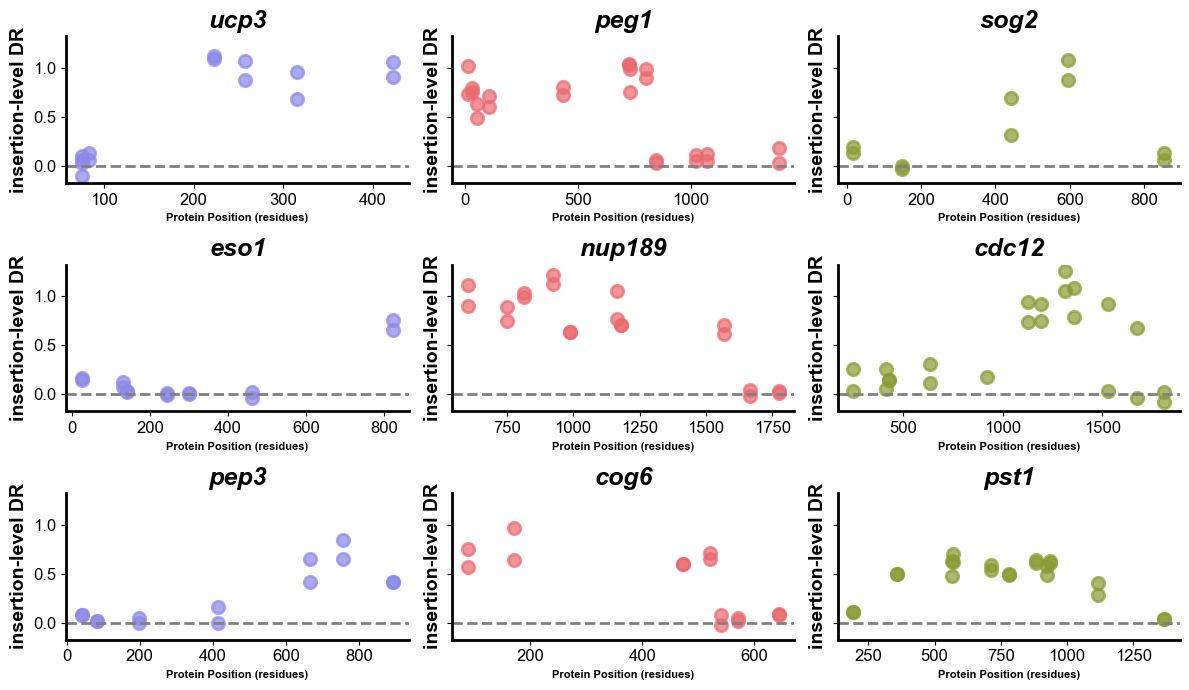

In [11]:
selected_genes = {
    "Non-essential N terminus": ["ucp3","eso1","pep3"],
    "Non-essential C terminus": ["peg1","nup189","cog6"],
    "Non-essential N terminus and C terminus": ["sog2","cdc12","pst1"]
}

col_colors = [
    COLORS["lavender_blue"],
    COLORS["coral_red"],
    COLORS["sage_green"]
]

fig, axes = plt.subplots(3,3, figsize=(12,7), sharey=True)

for col, (title, gene_list) in enumerate(selected_genes.items()):
    for row, gene in enumerate(gene_list):
        ax = axes[row, col]

        gene_insertions = in_gene_insertions.query("Name == @gene")
        gene_metrics = gene_statistics.loc[gene]

        gene_um = gene_metrics["um"]
        gene_lam = gene_metrics["lam"]

        ax.axhline(0, color="gray", linestyle="--", linewidth=2, label="gene-level um")

        x = gene_insertions['Residue_affected']
        y = gene_insertions["um"]

        ax.scatter(x, y, s=80, marker='o', label='Insertion', color=col_colors[col], alpha=0.7)
        
        ax.set_title(gene, fontstyle='italic', fontsize=18)
        ax.set_xlabel('Protein Position (residues)', fontsize=8, fontweight='bold')
        ax.set_ylabel("insertion-level DR")
        # if row == 0 and col == 2:
            # ax.legend(loc='best', fontsize=9, bbox_to_anchor=(1.4, 1.4))

plt.tight_layout()
plt.show()
plt.close()